In [1]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [2]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

In [3]:
train_data, test_data = datasets.load_dataset("fancyzhx/dbpedia_14", split=["train", "test"])

###### for now reduce in size to save time

In [4]:
### sample and reduce poth splits to 10% of the original size


print(f"Original train_data length: {len(train_data)}")
print(f"Original test_data length: {len(test_data)}")


train_data = train_data.select(indices=np.random.choice(len(train_data), len(train_data)//10))
test_data = test_data.select(indices=np.random.choice(len(test_data), len(test_data)//10))

print(f"Reduced train_data length: {len(train_data)}")
print(f"Reduced test_data length: {len(test_data)}")

Original train_data length: 25000
Original test_data length: 25000
Reduced train_data length: 2500
Reduced test_data length: 2500


In [4]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [6]:
xxx = train_data[0]
print(xxx)
print(type(xxx))

{'text': 'Amy Heckerling\'s second film Johnny Dangerously is a parody of 1930\'s gangster films made in the Warner Brothers\' tradition. Michael Keaton stars as a middle aged gangster looking back at his life of hard knocks when he catches a kid trying to steal something from his pet store in 1935. Keaton\'s mother (Maureen Stapleton) has continuing health problems, so Keaton falls into crime at an early age via Peter Boyle. Meanwhile, the fargan Richard Dimitri plays a rival crime lord to Boyle and Keaton eventually rises through the ranks. Joe Piscopo has a hilarious turn as Danny Vermin, yeah that\'s right, Vermin! Griffin Dunne is Keaton\'s younger brother turned district attorney, Glynnis O\'Connor his wife, and Marilu Henner plays Keaton\'s moll. The film looks notoriously cheap, making it seem like a television show instead of a theatrical film.<br /><br />The film starts out great and then slows down as expected after the first half hour. Due to the combination of dialog and g

In [11]:
###use  either the "tiles" or the "content" for tokenizations 
def tokenize_example_content(example, tokenizer, max_length):
    tokens = tokenizer(example["content"])[:max_length]
    return {"tokens": tokens}

def tokenize_example_title(example, tokenizer, max_length):
    tokens = tokenizer(example["title"])[:max_length]
    return {"tokens": tokens}

In [5]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [6]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

In [7]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [8]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [9]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [10]:
vocab.set_default_index(unk_index)

In [11]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [12]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

In [13]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [14]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [15]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [16]:
batch_size = 320

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [17]:
print("number of training samples: ", len(train_data))
print(1875-(batch_size * 5))

number of training samples:  18750
275


In [18]:
print(f"Number of train batches: {len(train_data_loader)}")
print(f"Number of valid batches: {len(valid_data_loader)}")
print(f"Number of test batches: {len(test_data_loader)}")

Number of train batches: 59
Number of valid batches: 20
Number of test batches: 79


In [19]:
def register_save_activations_hook(model, model_activation_layer, activations_list):
    """Registers a forward pass hook that saves activations.
    
    Args:
        model(nn.Module): A PyTorch model.
        model_activation_layer(str): The name of the module in the network that
            produces the activations of interest.
        activations_list(List[torch.Tensor]) The list in which we should store the
            model activations.
    """
    def save_activations(model, inp, out):
        # print(f"save_activations: {out.size()}")
        activs = out.view(out.size(0), -1).detach().cpu()       
        activations_list.append(activs)

    for name, m in model.named_modules():
        if name == model_activation_layer or \
          (isinstance(model, torch.nn.DataParallel) and \
           name.replace('module.', '') == model_activation_layer):
            return m.register_forward_hook(save_activations)
    return None

In [20]:
class CNN(nn.Module):



    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(embedding_dim, n_filters, filter_size)
                for filter_size in filter_sizes
            ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

        ## last layer name
        self.activation_layer_name =f"convs.{len(filter_sizes)-1}"

    def _init_activations_hook(self, model, activations_list):
        """Initializes the forward hook to save model activations."""
        if isinstance(model, torch.nn.DataParallel):
            activation_layer = model.module.activation_layer_name
        else:
            activation_layer = model.activation_layer_name
        activations_handle = register_save_activations_hook(model, activation_layer,
                                                            activations_list)
        if activation_layer is not None:
            assert activations_handle is not None, \
                f'No hook registered for activation_layer={activation_layer}'
        return activations_handle


    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        embedded = embedded.permute(0, 2, 1)
        # embedded = [batch size, embedding dim, seq len]
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]
        pooled = [conv.max(dim=-1).values for conv in conved]
        # pooled_n = [batch size, n filters]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        # cat = [batch size, n filters * len(filter_sizes)]
        prediction = self.fc(cat)
        # prediction = [batch size, output dim]
        return prediction

In [23]:
def get_model():    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    x = Reshape((m, n, 300))(x)
    #print(x)
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 2), 
                                                                                    activation='relu')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 3),
                                                                                    activation='relu')(x)
    
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 4),
                                                                                    activation='relu')(x)
    
    
    
    
    
    conv_4 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 1), 
                                                                                    activation='relu')(x)
    conv_5 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 2), activation='relu')(x)
    
    conv_6 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 3),
                                                                                    activation='relu')(x)
    
    
    
    maxpool_0 = MaxPool2D()(conv_0)
    maxpool_0=Flatten()(maxpool_0)
    maxpool_1 = MaxPool2D()(conv_1)
    maxpool_1=Flatten()(maxpool_1)
    maxpool_2 = MaxPool2D()(conv_2)
    maxpool_2 = Flatten()(maxpool_2)
    
    maxpool_4 = MaxPool2D()(conv_4)
    maxpool_4=Flatten()(maxpool_4)
    maxpool_5 = MaxPool2D()(conv_5)
    maxpool_5=Flatten()(maxpool_5)
    maxpool_6 = MaxPool2D()(conv_6)
    maxpool_6=Flatten()(maxpool_6)
    #maxpool_7 = MaxPool2D()(conv_7)
   # maxpool_7=Flatten()(maxpool_7)
    z = concatenate([maxpool_0, maxpool_1,maxpool_2],axis=1)
    w=concatenate([maxpool_4, maxpool_5,maxpool_6],axis=1)    
    #w=concatenate([maxpool_4, maxpool_5,maxpool_6],axis=1)    
    #z = concatenate([maxpool_0, maxpool_1,maxpool_2,maxpool_4, maxpool_5,maxpool_6],axis=1)
    #z = concatenate([maxpool_0, maxpool_1,maxpool_4, maxpool_5],axis=1)
    
    #z = Flatten()(z)
    z=concatenate([w,z],axis=1)
    z=Dense(units=64,activation="relu")(z)
    z = Dropout(0.4)(z)
        
    outp = Dense(1, activation="sigmoid")(z)
    
    model = Model(inputs=inp, outputs=outp)
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [21]:



class CNN_paper (nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()





        ## not even sure what the reason behind the values are
        self.m = 10
        self.n = 5
        self.penultimate_dim = 64

        self.num_filters = n_filters
        self.filter_sizes = [4,6]






        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.layer_spatial_dropout = nn.Dropout1d(0.4)
        self.convs = nn.ModuleList(
            [
                nn.Conv2d(embedding_dim,self.num_filters, kernel_size=(self.filter_sizes[0], 2)),
                nn.Conv2d(embedding_dim,self.num_filters, kernel_size=(self.filter_sizes[0], 3)),
                nn.Conv2d(embedding_dim,self.num_filters, kernel_size=(self.filter_sizes[0], 4)),
                nn.Conv2d(embedding_dim,self.num_filters, kernel_size=(self.filter_sizes[1], 1)),
                nn.Conv2d(embedding_dim,self.num_filters, kernel_size=(self.filter_sizes[1], 2)),
                nn.Conv2d(embedding_dim,self.num_filters, kernel_size=(self.filter_sizes[1], 3))
                
            ]
        )
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2))
        self.flatten = nn.Flatten()

        
        self.penultimate_layer = nn.Linear( 3 * self.num_filters, self.penultimate_dim )
        
        self.fc = nn.Linear(self.penultimate_dim , output_dim)
        self.dropout = nn.Dropout(dropout_rate)

        
        self.activation_layer_name =f"penultimate_layer"


    def _init_activations_hook(self, model, activations_list):
        """Initializes the forward hook to save model activations."""
        if isinstance(model, torch.nn.DataParallel):
            activation_layer = model.module.activation_layer_name
        else:
            activation_layer = model.activation_layer_name
        activations_handle = register_save_activations_hook(model, activation_layer,
                                                            activations_list)
        if activation_layer is not None:
            assert activations_handle is not None, \
                f'No hook registered for activation_layer={activation_layer}'
        return activations_handle


    def forward(self, ids):
        # # ids = [batch size, seq len]
        # embedded = self.dropout(self.embedding(ids))
        # # embedded = [batch size, seq len, embedding dim]
        # embedded = embedded.permute(0, 2, 1)
        # # embedded = [batch size, embedding dim, seq len]
        # conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]
        # pooled = [conv.max(dim=-1).values for conv in conved]
        # # pooled_n = [batch size, n filters]
        # cat = self.dropout(torch.cat(pooled, dim=-1))
        # # cat = [batch size, n filters * len(filter_sizes)]
        # prediction = self.fc(cat)
        # # prediction = [batch size, output dim]
        # return prediction


        embedded = self.embedding(ids)
        embedded = self.layer_spatial_dropout(embedded)
        # print(embedded.size())
        # embedded = torch.reshape(embedded, (self.m, self.n,300))

        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        
        ## this could be dne better..
        pooled = [self.maxpool(conv) for conv in conved]
        flattened = [self.flatten(pool) for pool in pooled]
        
        ## why not concatenate in one step????
        z = torch.cat(flattened[0,3], dim=-1)
        w = torch.cat(flattened[4,6], dim=-1)

        ## TODO look up the reasoning for this, this is strange..
        z = torch.cat(z,w, dim=-1)
        penultimate = torch.relu(self.penultimate_layer(z))
        penultimate = self.dropout(penultimate)
        prediction = self.fc(penultimate)

        return prediction


In [22]:
vocab_size = len(vocab)
embedding_dim = 300
n_filters = 100
filter_sizes = [3, 5, 7]
output_dim = len(train_data.unique("label"))
dropout_rate = 0.25

model = CNN(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    output_dim,
    dropout_rate,
    pad_index,
)

In [26]:
vocab_size = len(vocab)
embedding_dim = 300
n_filters = 100
# filter_sizes = [3, 5, 7]
filter_sizes = [4,6]
output_dim = len(train_data.unique("label"))
dropout_rate = 0.25

model = CNN_paper(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    output_dim,
    dropout_rate,
    pad_index,
)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 6,941,402 trainable parameters


In [24]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

In [25]:
model.apply(initialize_weights)

CNN(
  (embedding): Embedding(21635, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [26]:
vectors = torchtext.vocab.GloVe()

In [27]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [28]:
print(pretrained_embedding.shape)

torch.Size([21635, 300])


In [29]:
model.embedding.weight.data = pretrained_embedding

In [30]:
optimizer = optim.Adam(model.parameters())

In [31]:
criterion = nn.CrossEntropyLoss()

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [33]:
model = model.to(device)
criterion = criterion.to(device)

###
N, C, W, H

In [39]:

data_loader = train_data_loader


sel_batch = next(iter(data_loader))

print(sel_batch["ids"].size())
ids = sel_batch["ids"].to(device)

ids = ids.cpu()
vocab_size = len(vocab)
print(vocab_size)
embedding_dim = 300

print(pad_index)


embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)

print(embedding.weight.size())
emdd = embedding(ids)
print(emdd.size())
emdd = emdd.permute(0, 2, 1)
print(emdd.size())

conv = nn.Conv2d(embedding_dim,100, kernel_size=(4, 2))
conv1d = nn.Conv1d(embedding_dim,100, kernel_size=4)

print(conv.weight.size())
print(conv1d.weight.size())


# cd1d = conv1d(emdd)
cd = conv(emdd)


torch.Size([320, 256])
5197
1
torch.Size([5197, 300])
torch.Size([320, 256, 300])
torch.Size([320, 300, 256])
torch.Size([100, 300, 4, 2])
torch.Size([100, 300, 4])


RuntimeError: Given groups=1, weight of size [100, 300, 4, 2], expected input[1, 320, 300, 256] to have 300 channels, but got 320 channels instead

In [34]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [35]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    epoch_activations = []
    epoch_labels = []

    activations_handle = model._init_activations_hook(model, epoch_activations)

    debug_counter = 0

    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        epoch_labels.append(label.detach().cpu())
        
        # print(label.shape)
        # print(epoch_activations[-1].shape)

        # print("debug_counter: ", debug_counter)
        debug_counter += 1
    if activations_handle:
        # print("removing handle")
        activations_handle.remove()

    return np.mean(epoch_losses), np.mean(epoch_accs), epoch_activations, epoch_labels

In [36]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    epoch_activations = []
    epoch_labels = []

    activations_handle = model._init_activations_hook(model, epoch_activations)

    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            epoch_labels.append(label.detach().cpu())

    if activations_handle:
        activations_handle.remove()
    return np.mean(epoch_losses), np.mean(epoch_accs), epoch_activations, epoch_labels

In [37]:
from copy import deepcopy

state_dict = deepcopy(model.state_dict()) 

In [100]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

outputs = {}

for epoch in range(n_epochs):
    train_loss, train_acc, train_activations, train_labels = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc, val_activations, val_labels = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")



    ## cat the batches together

    train_activations = torch.cat(train_activations, dim=0)
    val_activations = torch.cat(val_activations, dim=0)

    train_labels = torch.cat(train_labels, dim=0)
    val_labels = torch.cat(val_labels, dim=0)

    ### save activations

    train_outputs = {
        "activations": train_activations,
        "labels": train_labels
    }
    val_outputs = {
        "activations": val_activations,
        "labels": val_labels
    }
    outputs[epoch] = {"train": train_outputs, "val": val_outputs}

evaluating...: 100%|██████████| 20/20 [00:00<00:00, 30.13it/s]


epoch: 0
train_loss: 0.740, train_acc: 0.644
valid_loss: 0.378, valid_acc: 0.833


evaluating...: 100%|██████████| 20/20 [00:00<00:00, 31.66it/s]


epoch: 1
train_loss: 0.422, train_acc: 0.811
valid_loss: 0.314, valid_acc: 0.866


evaluating...: 100%|██████████| 20/20 [00:00<00:00, 31.59it/s]


epoch: 2
train_loss: 0.329, train_acc: 0.860
valid_loss: 0.296, valid_acc: 0.878


evaluating...: 100%|██████████| 20/20 [00:00<00:00, 31.87it/s]


epoch: 3
train_loss: 0.272, train_acc: 0.888
valid_loss: 0.286, valid_acc: 0.884


evaluating...: 100%|██████████| 20/20 [00:00<00:00, 32.16it/s]


epoch: 4
train_loss: 0.223, train_acc: 0.912
valid_loss: 0.286, valid_acc: 0.885


evaluating...: 100%|██████████| 20/20 [00:00<00:00, 32.33it/s]


epoch: 5
train_loss: 0.179, train_acc: 0.934
valid_loss: 0.287, valid_acc: 0.883


evaluating...: 100%|██████████| 20/20 [00:00<00:00, 30.64it/s]


epoch: 6
train_loss: 0.148, train_acc: 0.947
valid_loss: 0.280, valid_acc: 0.892


evaluating...: 100%|██████████| 20/20 [00:00<00:00, 32.04it/s]


epoch: 7
train_loss: 0.113, train_acc: 0.960
valid_loss: 0.299, valid_acc: 0.885


evaluating...: 100%|██████████| 20/20 [00:00<00:00, 32.18it/s]


epoch: 8
train_loss: 0.089, train_acc: 0.970
valid_loss: 0.290, valid_acc: 0.893


evaluating...: 100%|██████████| 20/20 [00:00<00:00, 49.27it/s]


epoch: 9
train_loss: 0.071, train_acc: 0.979
valid_loss: 0.305, valid_acc: 0.887


In [39]:


for epoch in outputs:
    dicttt : dict = outputs[epoch]
    train_outputs = dicttt["train"]
    activations_t = train_outputs["activations"]
    print(activations_t.size())



torch.Size([18750, 25000])
torch.Size([18750, 25000])
torch.Size([18750, 25000])
torch.Size([18750, 25000])
torch.Size([18750, 25000])
torch.Size([18750, 25000])
torch.Size([18750, 25000])
torch.Size([18750, 25000])
torch.Size([18750, 25000])
torch.Size([18750, 25000])


In [107]:
print(model)

CNN(
  (embedding): Embedding(4196, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


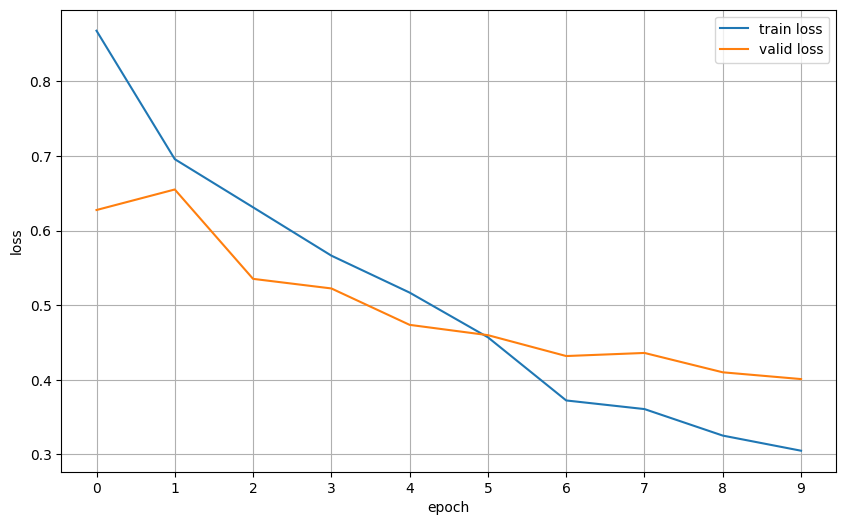

In [108]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

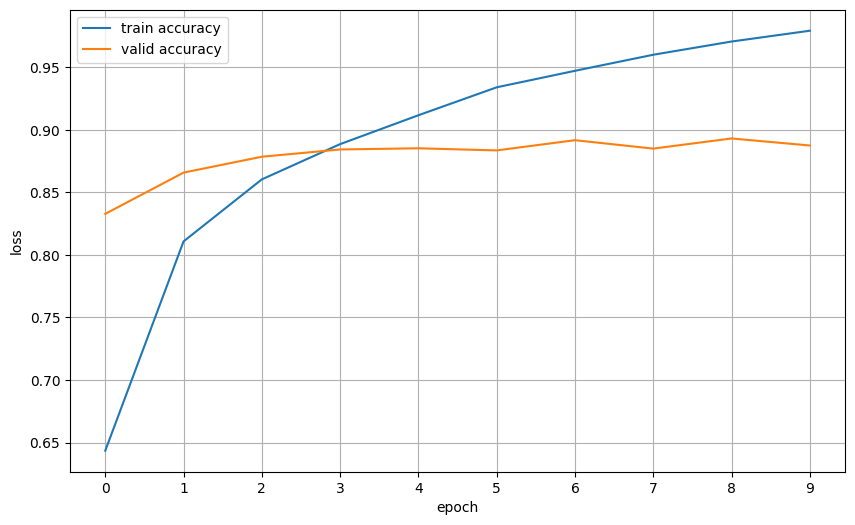

In [40]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [112]:
model.load_state_dict(torch.load("cnn.pt"))

test_loss, test_acc, test_activations, test_epoch_labels = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 8/8 [00:00<00:00, 31.91it/s]


In [113]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.420, test_acc: 0.797


In [48]:
def predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    if len(ids) < min_length:
        ids += [pad_index] * (min_length - len(ids))
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [49]:
text = "This film is terrible!"
min_length = max(filter_sizes)

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(12, 0.954708456993103)

In [50]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(12, 0.921493649482727)

In [51]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(12, 0.9487431049346924)

In [52]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(12, 0.9126440286636353)

In [41]:
torch.save(outputs, "outputs.pt")

In [115]:
activations = torch.load("outputs.pt")
print(activations.keys())
forth_epoch = activations[3]
print(forth_epoch.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys(['train', 'val'])


In [119]:
print(type(forth_epoch["train"]))
print(len(forth_epoch["train"]))

<class 'list'>
4


In [128]:
print(forth_epoch["train"][0].size())

torch.Size([512, 25000])


In [133]:
xxx = forth_epoch["train"][0]

In [135]:
print(xxx.size())

yyy = xxx.view(xxx.size(0), -1)
print(yyy.size())

torch.Size([512, 25000])
torch.Size([512, 25000])
